Simulated BGS galaxy spectra are generated using dark and bright sky spectrum then 
run through the `redrock` pipeline in order to measure redshifts. 



In [1]:
import os
import numpy as np 
# -- astropy --
from astropy.io import fits
from desispec.io import read_spectra
from desispec.io import write_spectra
from desispec.spectra import Spectra
# -- local --
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Read in Gama-Legacy catalog

In [3]:
cata = Cat.GamaLegacy()
gleg = cata.Read()

properties of the GAMA-Legacy survey 

In [17]:
redshift = gleg['gama-spec']['z_helio']
ngal = len(redshift)
print('%i galaxies in the GAMA-Legacy survey' % ngal)

39832 galaxies in the GAMA-Legacy survey


In [124]:
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# apparent magnitude from Legacy photometry aperture flux
g_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_g'][:,1])
r_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
# apparent magnitude from GAMA photometry
g_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_g'])
r_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_r'])
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]

/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


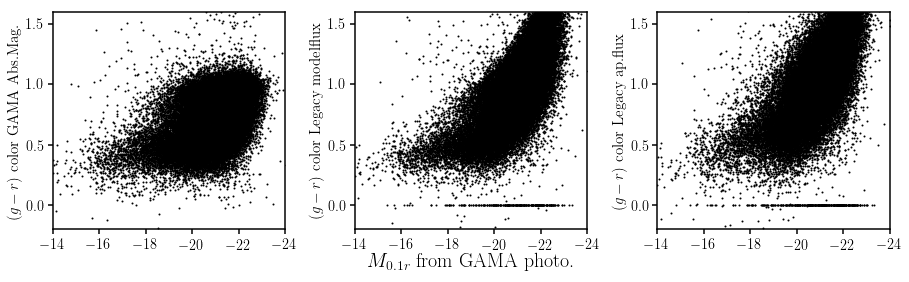

In [109]:
fig = plt.figure(figsize=(15, 4))
ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, y, ylbl in zip(range(1,4), ys, ylbls):
    sub = fig.add_subplot(1,3,i)
    sub.scatter(r_absmag_gama, y, c='k', s=1.)
    if i == 2: sub.set_xlabel('$M_{0.1r}$ from GAMA photo.', fontsize=20)
    sub.set_xlim([-14., -24])
    sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
    sub.set_ylim([-0.2, 1.6])
fig.subplots_adjust(wspace=0.3)

/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


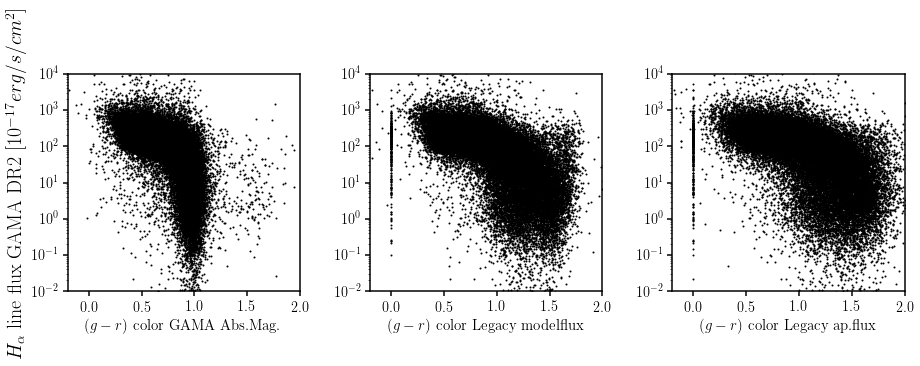

In [127]:
fig = plt.figure(figsize=(15, 4))
xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
    sub = fig.add_subplot(1, len(xs), i)
    sub.scatter(x, gama_ha, s=1, c='k')
    sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
    sub.set_xlim([-0.2, 2.])
    if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
    sub.set_ylim([1e-2, 1e4])
    sub.set_yscale('log')
fig.subplots_adjust(wspace=0.3)

Read in the `redrock` redshift measurements for a subsample of the simulated spectra 

In [10]:
f_z_dark = ''.join([UT.dat_dir(), 'redrock/', 'gama_legacy.expSpectra.darksky.seed1.1of40blocks.zbest.fits'])
zdark_data = fits.open(f_z_dark)[1].data

f_i_dark = ''.join([UT.dat_dir(), 'spectra/', 'gama_legacy.expSpectra.darksky.seed1.1of40blocks.index'])
i_dark = np.loadtxt(f_i_dark, unpack=True, usecols=[0], dtype='i')

f_z_bright = ''.join([UT.dat_dir(), 'redrock/', 'gama_legacy.expSpectra.brightsky.seed1.1of40blocks.zbest.fits'])
zbright_data = fits.open(f_z_bright)[1].data

f_i_bright = ''.join([UT.dat_dir(), 'spectra/', 'gama_legacy.expSpectra.brightsky.seed1.1of40blocks.index']) 
i_bright = np.loadtxt(f_i_bright, unpack=True, usecols=[0], dtype='i')

In [11]:
print('%i redshifts' % len(zdark_data['Z']))

994 redshifts


In [12]:
assert np.array_equal(i_dark, i_bright)

In [13]:
z_gama = redshift[i_dark]

A number of galaxies have no fiber flux, so lets impose a magnitude cut

In [14]:
mag_cut = (r_mag[i_dark] < 25.0)
print('%f remain after mag cut' % (float(np.sum(mag_cut))/float(len(i_dark))))
print('%i galaxies remaining' % np.sum(mag_cut))

0.901408 remain after mag cut
896 galaxies remaining


/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until


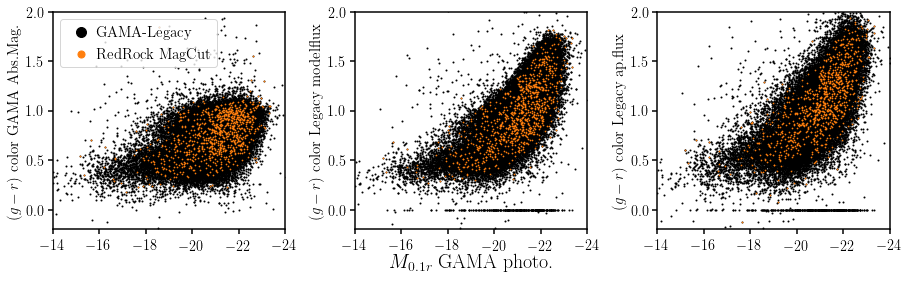

In [112]:
fig = plt.figure(figsize=(15, 4))
ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, y, ylbl in zip(range(1,4), ys, ylbls):
    sub = fig.add_subplot(1,3,i)
    sub.scatter(r_absmag_gama, y, c='k', s=1., label='GAMA-Legacy')
    sub.scatter(r_absmag_gama[i_dark][mag_cut], y[i_dark][mag_cut], c='C1', s=0.5, label='RedRock MagCut')
    if i == 2: sub.set_xlabel('$M_{0.1r}$ GAMA photo.', fontsize=20)
    sub.set_xlim([-14., -24])
    sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
    sub.set_ylim([-0.2, 2.])
    if i == 1: sub.legend(loc="upper left", markerscale=10, handletextpad=0., frameon=True, prop={'size':15})
fig.subplots_adjust(wspace=0.3)

/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


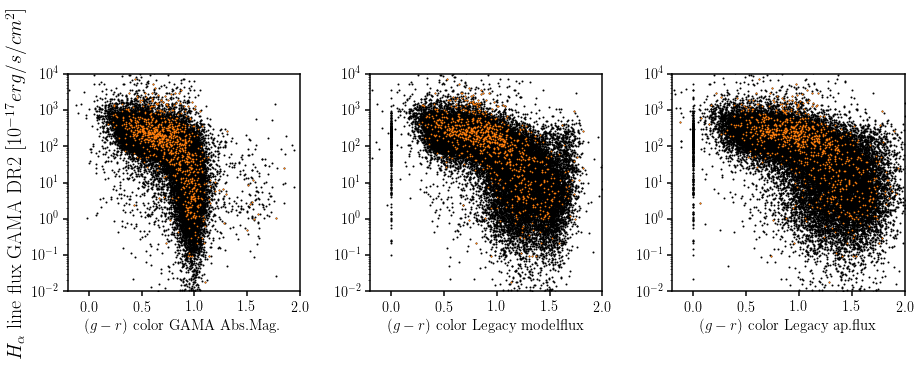

In [128]:
fig = plt.figure(figsize=(15, 4))
xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
    sub = fig.add_subplot(1, len(xs), i)
    sub.scatter(x, gama_ha, s=1, c='k', label='GAMA-Legacy')
    sub.scatter(x[i_dark][mag_cut], gama_ha[i_dark][mag_cut], c='C1', s=0.5, label='RedRock MagCut')
    sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
    sub.set_xlim([-0.2, 2.])
    if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
    sub.set_ylim([1e-2, 1e4])
    sub.set_yscale('log')
fig.subplots_adjust(wspace=0.3)

(18, 22.0)

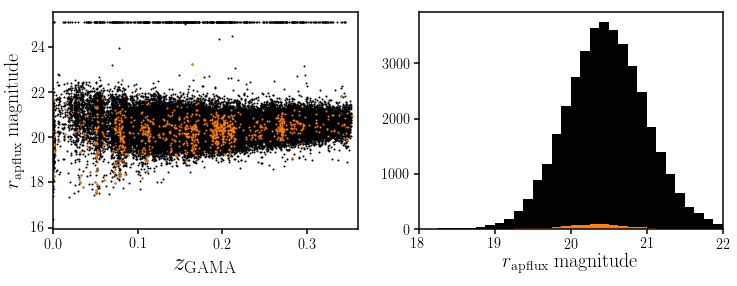

In [49]:
fig = plt.figure(figsize=(12,4))
sub1 = fig.add_subplot(121)
sub1.scatter(redshift, r_mag_legacy_apflux, s=1, c='k')
sub1.scatter(z_gama[mag_cut], r_mag_legacy_apflux[i_dark][mag_cut], s=1, c='C1')
sub1.set_xlabel(r'$z_\mathrm{GAMA}$', fontsize=25)
sub1.set_xlim([0., 0.36])
sub1.set_ylabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub2 = fig.add_subplot(122)
_ = sub2.hist(r_mag_legacy_apflux, histtype='stepfilled', range=(17, 22), bins=40, color='k')
_ = sub2.hist(r_mag_legacy_apflux[i_dark][mag_cut], histtype='stepfilled', range=(17, 22), bins=40, color='C1')
sub2.set_xlabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub2.set_xlim([18, 22.])

Lets compare the redshift we measure from redrock to the "true" input redshift from GAMA. 

(0.7, 1.0)

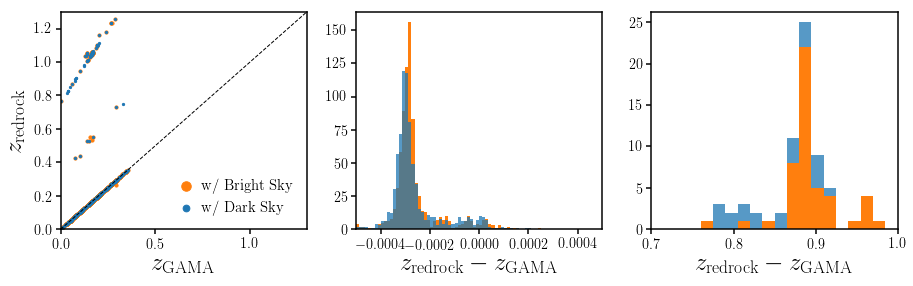

In [82]:
fig = plt.figure(figsize=(15,4))
sub = fig.add_subplot(131)
sub.scatter(z_gama[mag_cut], zbright_data['Z'][mag_cut], c='C1', s=10, label='w/ Bright Sky')
sub.scatter(z_gama[mag_cut], zdark_data['Z'][mag_cut], c='C0', s=5, label='w/ Dark Sky')
sub.plot([0., 10.], [0., 10.], c='k', lw=1, ls='--')
sub.set_xlabel(r"$z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([0., 1.3])
sub.set_ylabel(r"$z_\mathrm{redrock}$", fontsize=25)
sub.set_ylim([0., 1.3])
sub.legend(loc='lower right', markerscale=3, handletextpad=0., prop={'size':15})
sub = fig.add_subplot(132)
_ = sub.hist(zbright_data['Z'][mag_cut] - z_gama[mag_cut], color='C1', 
             range=(-0.00075, 0.0005), bins=100, histtype='stepfilled', label='w/ Bright Sky')
_ = sub.hist(zdark_data['Z'][mag_cut] - z_gama[mag_cut], color='C0', 
             range=(-0.00075, 0.0005), bins=100, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
sub.set_xlabel(r"$z_\mathrm{redrock} - z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([-0.0005, 0.0005])
sub = fig.add_subplot(133)
_ = sub.hist(zdark_data['Z'][mag_cut] - z_gama[mag_cut], color='C0', 
             range=(0.7, 1), bins=20, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
_ = sub.hist(zbright_data['Z'][mag_cut] - z_gama[mag_cut], color='C1', 
             range=(0.7,1.), bins=20, histtype='stepfilled', label='w/ Bright Sky')
sub.set_xlabel(r"$z_\mathrm{redrock} - z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([0.7, 1.0])

In [69]:
print('Dark Sky: %i galaxies have Delta z > 0.1' % np.sum(zdark_data['Z'][mag_cut] - z_gama[mag_cut] > 0.1))
print('Bright Sky: %i galaxies have Delta z > 0.1' % np.sum(zbright_data['Z'][mag_cut] - z_gama[mag_cut] > 0.1))

Dark Sky: 84 galaxies have Delta z > 0.1
Bright Sky: 66 galaxies have Delta z > 0.1


What type of galaxies are these outliers...

/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """


Text(0.5,0.98,'galaxies with $\\Delta z > 0.1$')

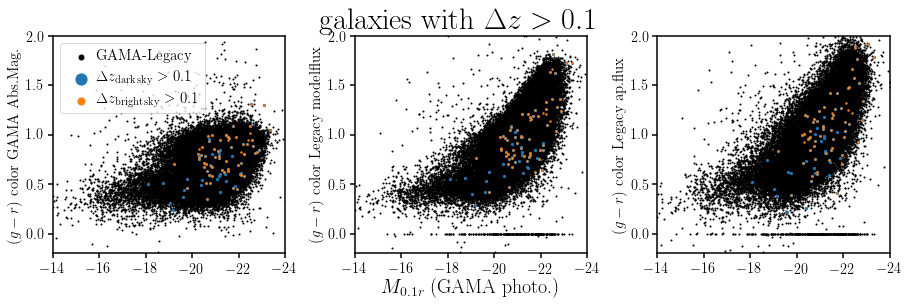

In [113]:
dark_zfail = (zdark_data['Z'][mag_cut] - z_gama[mag_cut] > 0.1) 
bright_zfail = (zbright_data['Z'][mag_cut] - z_gama[mag_cut] > 0.1)
fig = plt.figure(figsize=(15, 4))

ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, y, ylbl in zip(range(1,4), ys, ylbls):
    sub = fig.add_subplot(1,3,i)
    sub.scatter(r_absmag_gama, y, c='k', s=1., label='GAMA-Legacy')
    sub.scatter(r_absmag_gama[i_dark][mag_cut][dark_zfail], y[i_dark][mag_cut][dark_zfail], c='C0', s=5, 
                label='$\Delta z_\mathrm{dark\,sky} > 0.1$')
    sub.scatter(r_absmag_gama[i_dark][mag_cut][bright_zfail], y[i_dark][mag_cut][bright_zfail], c='C1', s=2, 
                label='$\Delta z_\mathrm{bright\,sky} > 0.1$')
    if i == 2: sub.set_xlabel('$M_{0.1r}$ (GAMA photo.)', fontsize=20)
    sub.set_xlim([-14., -24])
    sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
    sub.set_ylim([-0.2, 2.])
    if i == 1: sub.legend(loc="upper left", markerscale=5, handletextpad=0., frameon=True, prop={'size':15})
fig.subplots_adjust(wspace=0.3)
plt.suptitle('galaxies with $\Delta z > 0.1$', fontsize=30)

/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


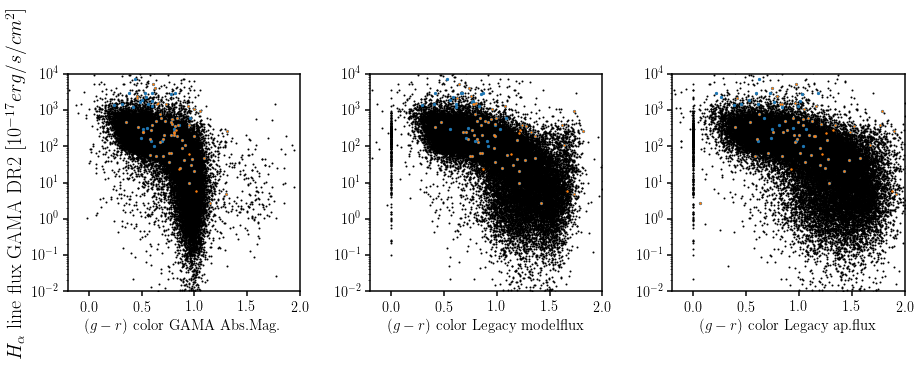

In [129]:
fig = plt.figure(figsize=(15, 4))
xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
    sub = fig.add_subplot(1, len(xs), i)
    sub.scatter(x, gama_ha, s=1, c='k', label='GAMA-Legacy')
    sub.scatter(x[i_dark][mag_cut][dark_zfail], gama_ha[i_dark][mag_cut][dark_zfail], c='C0', s=5, 
                label='$\Delta z_\mathrm{dark\,sky} > 0.1$')
    sub.scatter(x[i_dark][mag_cut][bright_zfail], gama_ha[i_dark][mag_cut][bright_zfail], c='C1', s=2, 
                label='$\Delta z_\mathrm{bright\,sky} > 0.1$')    
    sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
    sub.set_xlim([-0.2, 2.])
    if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
    sub.set_ylim([1e-2, 1e4])
    sub.set_yscale('log')
fig.subplots_adjust(wspace=0.3)

Based on $\Delta z$, `redrock` recovers redshifts is more successfully for spectra observed with bright sky...

In [71]:
dz_1pz_dark = (zdark_data['Z'] - z_gama)/(1.+z_gama)
dz_1pz_bright = (zbright_data['Z'] - z_gama)/(1.+z_gama)

(0.75, 0.85)

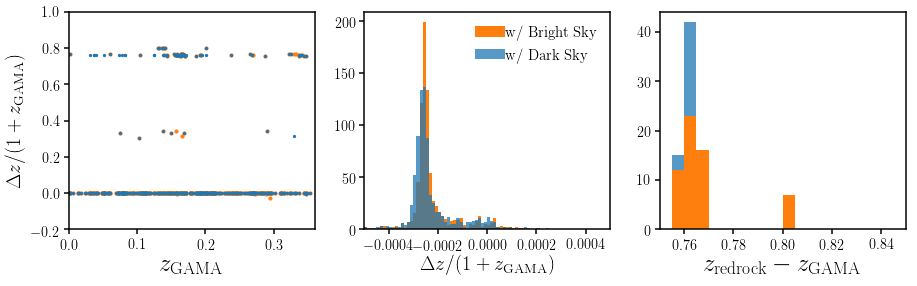

In [81]:
fig = plt.figure(figsize=(15,4))
sub = fig.add_subplot(131)
sub.scatter(z_gama[mag_cut], dz_1pz_bright[mag_cut], c='C1', s=10, label='w/ Bright Sky')
sub.scatter(z_gama[mag_cut], dz_1pz_dark[mag_cut], c='C0', s=5, label='w/ Dark Sky')
sub.set_xlabel(r"$z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([0., 0.36])
sub.set_ylabel(r"$\Delta z / (1+z_\mathrm{GAMA})$", fontsize=20)
sub.set_ylim([-0.2, 1.])
sub = fig.add_subplot(132)
_ = sub.hist(dz_1pz_bright[mag_cut], color='C1', 
             range=(-0.00075, 0.0005), bins=100, histtype='stepfilled', label='w/ Bright Sky')
_ = sub.hist(dz_1pz_dark[mag_cut], color='C0', 
             range=(-0.00075, 0.0005), bins=100, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
sub.set_xlabel(r"$\Delta z / (1+z_\mathrm{GAMA})$", fontsize=20)
sub.legend(loc='upper right', markerscale=3, handletextpad=0., prop={'size':15})
sub.set_xlim([-0.0005, 0.0005])
sub = fig.add_subplot(133)
_ = sub.hist(dz_1pz_dark[mag_cut], color='C0', 
             range=(0.75, 0.85), bins=20, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
_ = sub.hist(dz_1pz_bright[mag_cut], color='C1', 
             range=(0.75, 0.85), bins=20, histtype='stepfilled', label='w/ Bright Sky')
sub.set_xlabel(r"$z_\mathrm{redrock} - z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([0.75, 0.85])

In [83]:
print('Dark Sky: %i galaxies have dz/(1+z) > 0.1' % np.sum(dz_1pz_dark[mag_cut] > 0.1))
print('Bright Sky: %i galaxies have dz/(1+z) > 0.1' % np.sum(dz_1pz_bright[mag_cut] > 0.1))

Dark Sky: 84 galaxies have dz/(1+z) > 0.1
Bright Sky: 66 galaxies have dz/(1+z) > 0.1


Also based on $\Delta z/(1+z)$, `redrock` recovers redshifts is more successfully for spectra observed with bright sky...

The galaxies with large $\Delta z$ or $\Delta/(1+z)$ are galaxies with significant emission lines... This may be some issue with `redrock`. Moreover, these are not really the galaxies we're concerned about for this project so lets ignore them for now....

In [132]:
# the dz outliers are **mainly** affecting 
no_dz_outlier = (zdark_data['Z'][mag_cut] - z_gama[mag_cut] < 0.1)

(0.0, 0.0001)

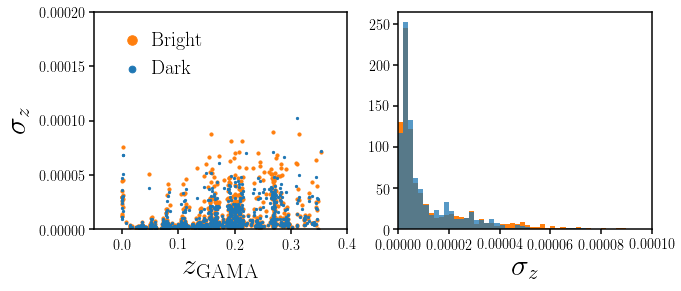

In [89]:
fig = plt.figure(figsize=(10,4))
sub = fig.add_subplot(121)
sub.scatter(z_gama[mag_cut], zbright_data['ZERR'][mag_cut], c='C1', s=10, label='Bright')
sub.scatter(z_gama[mag_cut], zdark_data['ZERR'][mag_cut], c='C0', s=5, label='Dark')
sub.set_xlabel(r"$z_\mathrm{GAMA}$", fontsize=30)
sub.set_xlim([-0.05, 0.4])
sub.set_ylabel(r"$\sigma_z$", fontsize=30)
sub.set_ylim([0, 2e-4])
sub.legend(loc='upper left', markerscale=3, handletextpad=0.0, prop={'size': 20})
sub = fig.add_subplot(122)
_ = sub.hist(zbright_data['ZERR'][mag_cut], color='C1', 
             range=(0., 0.0001), bins=50, histtype='stepfilled', label='w/ Bright Sky')
_ = sub.hist(zdark_data['ZERR'][mag_cut], color='C0', 
             range=(0., 0.0001), bins=50, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
sub.set_xlabel(r"$\sigma_z$", fontsize=30)
sub.set_xlim([0., 0.0001])

At least, the redshift measurement from `redrock` have larger uncertainties for the bright sky. 

Now lets see the redshift success rate (quantified as $\Delta z/(1+z) < 0.01$) as a function of various parameters. 

In [134]:
def gethist(var, ztrue, zbest, range=None, threshold=0.003):
    """ 
    """
    dz = zbest - ztrue
    dz_1pz = np.abs(dz)/(1.+ztrue)
    s1 = (dz_1pz < threshold)
    
    h0, bins = np.histogram(var, bins=20, range=range)
    hv, _ = np.histogram(var, bins=bins, weights=var)
    h1, _ = np.histogram(var[s1], bins=bins)
    
    good = h0 > 2
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    vv = hv / h0 # weighted mean of var
    
    def _eff(k, n):
        eff = k.astype("float") / (n.astype('float') + (n==0))
        efferr = np.sqrt(eff * (1 - eff)) / np.sqrt(n.astype('float') + (n == 0))
        return eff, efferr
    
    e1, ee1 = _eff(h1, h0)

    return vv, e1, ee1

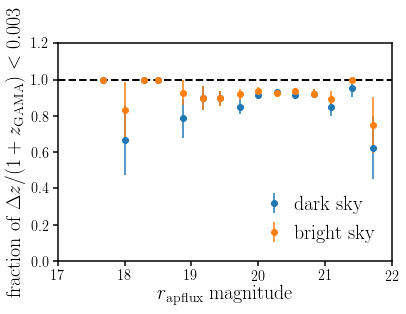

In [135]:
mm_dark, e1_dark, ee1_dark = gethist(r_mag[i_dark][mag_cut], z_gama[mag_cut], zdark_data['Z'][mag_cut])
mm_bright, e1_bright, ee1_bright = gethist(r_mag[i_dark][mag_cut], z_gama[mag_cut], zbright_data['Z'][mag_cut])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([17., 22.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, c='C1', fmt='o', label="bright sky")
sub.set_xlabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub.set_xlim([17., 22.])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', handletextpad=0., prop={'size': 20})

Now excluding the outliers where the redshifts are waaay off

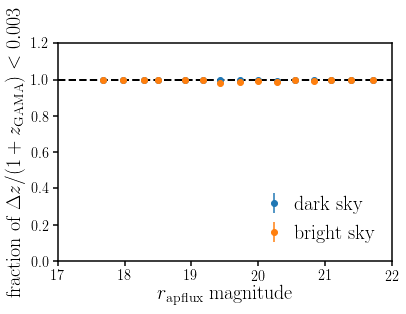

In [136]:
mm_dark, e1_dark, ee1_dark = gethist(r_mag[i_dark][mag_cut][no_dz_outlier], 
                                     z_gama[mag_cut][no_dz_outlier], 
                                     zdark_data['Z'][mag_cut][no_dz_outlier])
mm_bright, e1_bright, ee1_bright = gethist(r_mag[i_dark][mag_cut][no_dz_outlier], 
                                           z_gama[mag_cut][no_dz_outlier], 
                                           zbright_data['Z'][mag_cut][no_dz_outlier])
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([17., 22.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, c='C1', fmt='o', label="bright sky")
sub.set_xlabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub.set_xlim([17., 22.])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', handletextpad=0., prop={'size': 20})

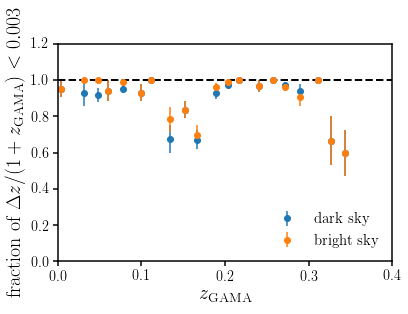

In [33]:
mm_dark, e1_dark, ee1_dark = gethist(redshift[i_dark][mag_cut], z_gama[mag_cut], zdark_data['Z'][mag_cut])
mm_bright, e1_bright, ee1_bright = gethist(redshift[i_dark][mag_cut], z_gama[mag_cut], zbright_data['Z'][mag_cut])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([0., 0.5], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, c='C1', fmt='o', label="bright sky")
sub.set_xlabel(r'$z_\mathrm{GAMA}$', fontsize=20)
sub.set_xlim([0.0, 0.4])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', prop={'size': 15})

In [34]:
gama_ha = gleg['gama-spec']['ha']
legacy_g = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
legacy_r = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
legacy_gr = legacy_g - legacy_r

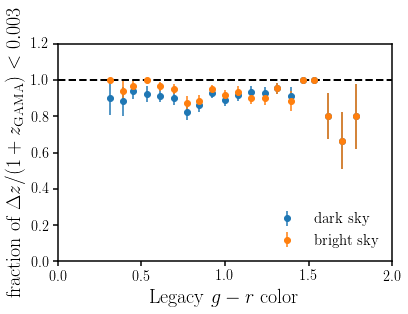

In [35]:
mm_dark, e1_dark, ee1_dark = gethist(legacy_gr[i_dark][mag_cut], z_gama[mag_cut], zdark_data['Z'][mag_cut])
mm_bright, e1_bright, ee1_bright = gethist(legacy_gr[i_dark][mag_cut], z_gama[mag_cut], zbright_data['Z'][mag_cut])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([0., 2.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, c='C1', fmt='o', label="bright sky")
sub.set_xlabel(r'Legacy $g-r$ color', fontsize=20)
sub.set_xlim([0., 2.])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', prop={'size': 15})

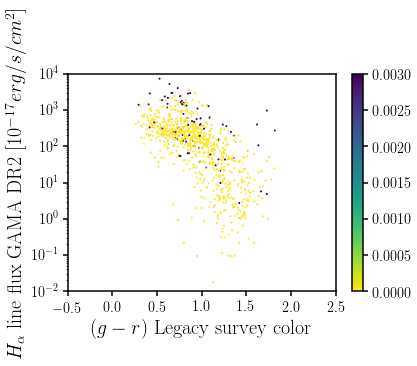

In [36]:
fig = plt.figure()
sub = fig.add_subplot(111)
cc = sub.scatter(legacy_gr[i_dark][mag_cut], gama_ha[i_dark][mag_cut], s=1, c=dz_1pz_dark[mag_cut], 
                 cmap='viridis_r', vmin=0, vmax=0.003)
sub.set_xlabel('$(g-r)$ Legacy survey color', fontsize=20)
sub.set_xlim([-0.5, 2.5])
sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_ylim([1e-2, 1e4])
sub.set_yscale('log')
fig.colorbar(cc)

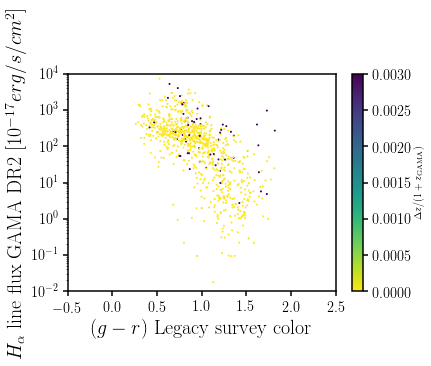

In [37]:
fig = plt.figure()
sub = fig.add_subplot(111)
cc = sub.scatter(legacy_gr[i_dark][mag_cut], gama_ha[i_dark][mag_cut], s=1, c=dz_1pz_bright[mag_cut], 
                 cmap='viridis_r', vmin=0, vmax=0.003)
sub.set_xlabel('$(g-r)$ Legacy survey color', fontsize=20)
sub.set_xlim([-0.5, 2.5])
sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_ylim([1e-2, 1e4])
sub.set_yscale('log')
fig.colorbar(cc, label=r'$\Delta z/(1+z_\mathrm{GAMA})$')

Lets compare the spectra w/ bright sky versus spectra w/ dark sky, for cases where the bright sky spectra produces more accurate redshifts

In [38]:
spec_dark = read_spectra(''.join([UT.dat_dir(), 'spectra/', 'gama_legacy.expSpectra.darksky.seed1.1of40blocks.fits']))
spec_bright = read_spectra(''.join([UT.dat_dir(), 'spectra/', 'gama_legacy.expSpectra.brightsky.seed1.1of40blocks.fits']))

In [39]:
weird = (np.abs(dz_1pz_bright) < np.abs(dz_1pz_dark)) & mag_cut
print('weird %i' % np.sum(weird))
veryweird = (dz_1pz_dark - dz_1pz_bright > 0.01) & mag_cut
print('very weird %i ' % np.sum(veryweird))
notveryweird = (dz_1pz_bright - dz_1pz_dark > 0.01) & mag_cut
print('not very weird %i' % np.sum(notveryweird)) 

weird 636
very weird 25 
not very weird 7


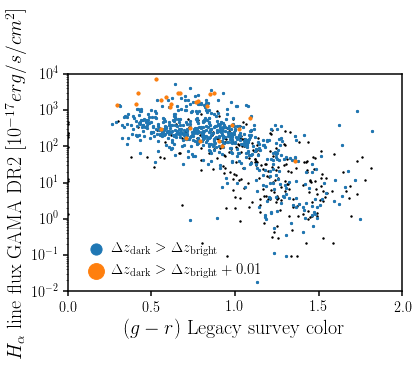

In [40]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(legacy_gr[i_dark], gama_ha[i_dark], s=2, c='k')
sub.scatter(legacy_gr[i_dark][weird], gama_ha[i_dark][weird], s=5, c='C0', 
            label='$\Delta z_\mathrm{dark} > \Delta z_\mathrm{bright}$')
sub.scatter(legacy_gr[i_dark][veryweird], gama_ha[i_dark][veryweird], s=10, c='C1', 
            label='$\Delta z_\mathrm{dark} > \Delta z_\mathrm{bright} + 0.01$')
sub.set_xlabel('$(g-r)$ Legacy survey color', fontsize=20)
sub.set_xlim([0, 2.])
sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_ylim([1e-2, 1e4])
sub.set_yscale('log')
sub.legend(loc='lower left', markerscale=5, handletextpad=0., prop={'size': 15})

Gama-Legacy index = 423
Gama-Legacy index = 484
Gama-Legacy index = 580
Gama-Legacy index = 628
Gama-Legacy index = 636


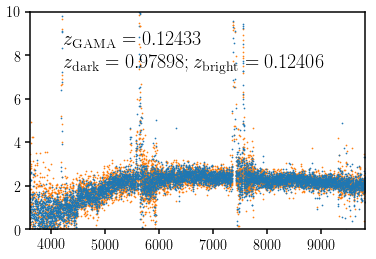

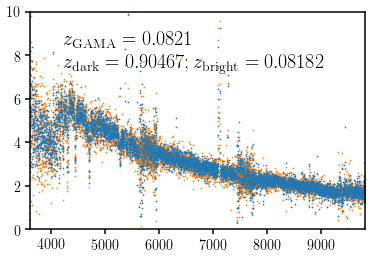

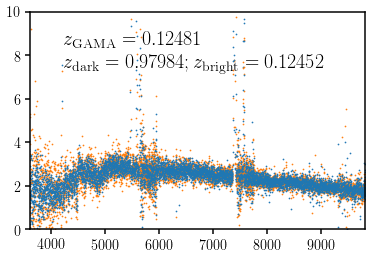

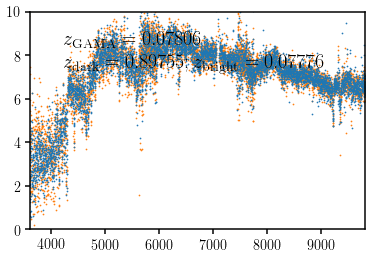

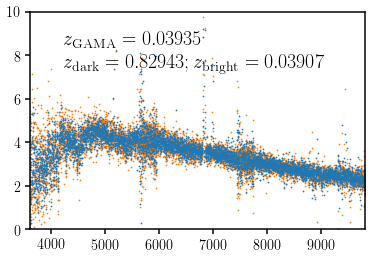

In [43]:
for i in np.arange(spec_dark.flux['b'].shape[0])[veryweird][10:15]: 
    fig = plt.figure()
    sub = fig.add_subplot(111)
    for band in ['b', 'r', 'z']:
        sub.scatter(spec_bright.wave[band], spec_bright.flux[band][i].flatten(), c='C1', s=0.5)
        sub.scatter(spec_dark.wave[band], spec_dark.flux[band][i].flatten(), c='C0', s=0.5)
    print('Gama-Legacy index = %i' % i_dark[i])
    #print(spec_bright.fibermap[i])
    #print(spec_dark.fibermap[i])
    sub.text(0.1, 0.9, 
             r'$z_\mathrm{GAMA}='+str(redshift[i_dark[i]])+'$ \n $z_\mathrm{dark}='+str(round(zdark_data['Z'][i],5))+'; z_\mathrm{bright} = '+str(round(zbright_data['Z'][i],5))+'$', 
             ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_xlim([3600., 9800.])
    sub.set_ylim([0., 10.])

Gama-Legacy index = 89
Gama-Legacy index = 122
Gama-Legacy index = 180
Gama-Legacy index = 187


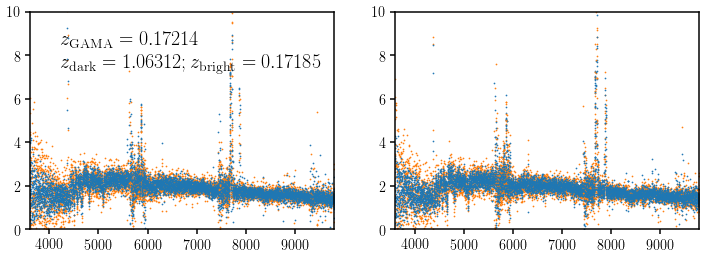

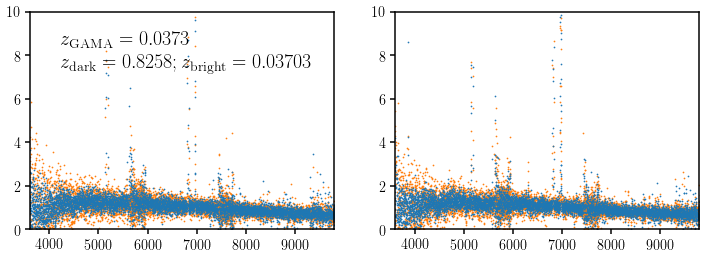

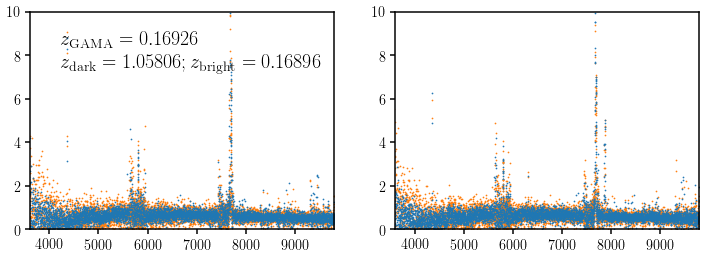

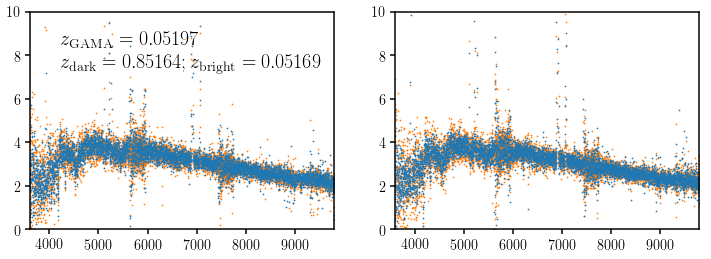

In [42]:
for i in np.arange(spec_dark.flux['b'].shape[0])[veryweird][:4]: 
    fig = plt.figure(figsize=(12,4))
    sub = fig.add_subplot(121)
    for band in ['b', 'r', 'z']:
        sub.scatter(spec_bright.wave[band], spec_bright.flux[band][i].flatten(), c='C1', s=0.5)
        sub.scatter(spec_dark.wave[band], spec_dark.flux[band][i].flatten(), c='C0', s=0.5)
    print('Gama-Legacy index = %i' % i_dark[i])
    sub.set_xlim([3600., 9800.])
    sub.set_ylim([0., 10.])
    sub.text(0.1, 0.9, 
             r'$z_\mathrm{GAMA}='+str(redshift[i_dark[i]])+'$ \n $z_\mathrm{dark}='+str(round(zdark_data['Z'][i],5))+'; z_\mathrm{bright} = '+str(round(zbright_data['Z'][i],5))+'$', 
             ha='left', va='top', fontsize=20, transform=sub.transAxes)
    
    obj_bright = read_spectra(''.join([UT.dat_dir(), 'obj', str(i_dark[i]), '.brightsky.fits']))
    obj_dark = read_spectra(''.join([UT.dat_dir(), 'obj', str(i_dark[i]), '.darksky.fits']))
    sub = fig.add_subplot(122)
    for band in ['b', 'r', 'z']:
        sub.scatter(obj_bright.wave[band], obj_bright.flux[band][0].flatten(), c='C1', s=0.5)
        sub.scatter(obj_dark.wave[band], obj_dark.flux[band][0].flatten(), c='C0', s=0.5)
    
    sub.set_xlim([3600., 9800.])
    sub.set_ylim([0., 10.])

In [60]:
print spec_dark.extra

None


In [82]:
for i in np.arange(spec_dark.flux['b'].shape[0])[veryweird]: 
    for i_spec, spec in enumerate([spec_bright, spec_dark]): 
        flux_dict = {} 
        ivar_dict = {}
        reso_dict = {}
        mask_dict = {}
        for band in ['b', 'r', 'z']:
            flux_dict[band] = spec.flux[band][i,:].reshape(1,-1)
            ivar_dict[band] = spec.ivar[band][i,:].reshape(1,-1)
            reso_dict[band] = np.array([spec.resolution_data[band][i,:,:]])
            mask_dict[band] = spec.mask[band][i,:].reshape(1,-1)
        ss = Spectra(bands=['b', 'r', 'z'], wave=spec.wave, flux=flux_dict, ivar=ivar_dict, mask=mask_dict, 
               resolution_data=reso_dict, fibermap=spec.fibermap[np.array([i])], meta=spec.meta, extra=None, single=spec._single)
        if i_spec == 0: 
            write_spectra(''.join([UT.dat_dir(), 'weird_obj', str(i_dark[i]), '.brightsky.fits']), ss)
        elif i_spec == 1: 
            write_spectra(''.join([UT.dat_dir(), 'weird_obj', str(i_dark[i]), '.darksky.fits']), ss)

Gama-Legacy index = 89
Gama-Legacy index = 122
Gama-Legacy index = 180
Gama-Legacy index = 187


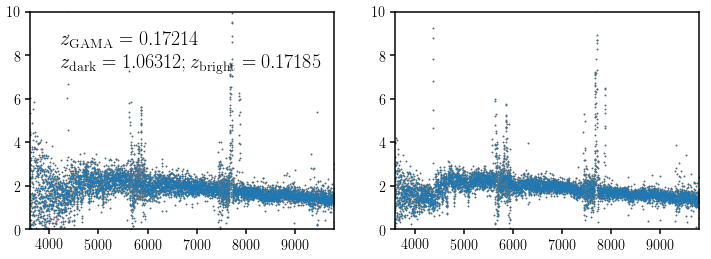

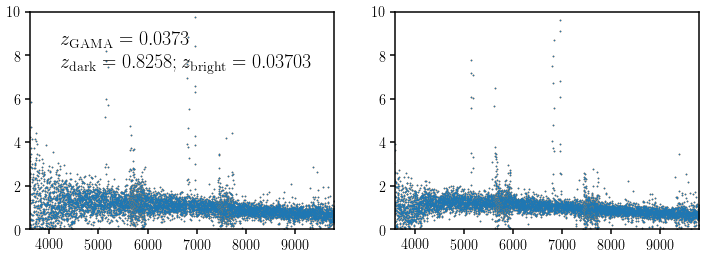

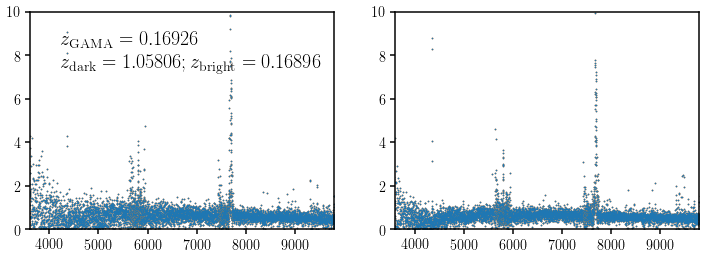

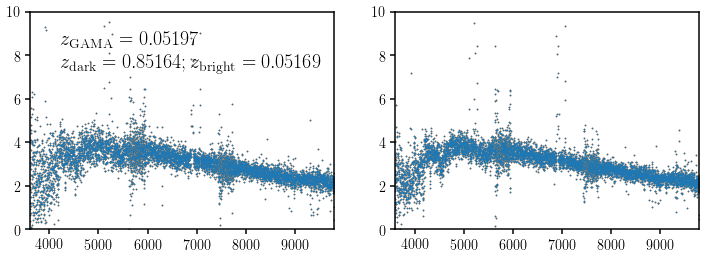

In [85]:
for i in np.arange(spec_dark.flux['b'].shape[0])[veryweird][:4]: 
    obj_bright = read_spectra(''.join([UT.dat_dir(), 'weird_obj', str(i_dark[i]), '.brightsky.fits']))
    obj_dark = read_spectra(''.join([UT.dat_dir(), 'weird_obj', str(i_dark[i]), '.darksky.fits']))
    
    fig = plt.figure(figsize=(12,4))
    sub = fig.add_subplot(121)
    for band in ['b', 'r', 'z']:
        sub.scatter(spec_bright.wave[band], spec_bright.flux[band][i].flatten(), c='C1', s=0.5)
        sub.scatter(obj_bright.wave[band], obj_bright.flux[band][0].flatten(), c='C0', s=0.5)

    print('Gama-Legacy index = %i' % i_dark[i])
    sub.set_xlim([3600., 9800.])
    sub.set_ylim([0., 10.])
    sub.text(0.1, 0.9, 
             r'$z_\mathrm{GAMA}='+str(redshift[i_dark[i]])+'$ \n $z_\mathrm{dark}='+str(round(zdark_data['Z'][i],5))+'; z_\mathrm{bright} = '+str(round(zbright_data['Z'][i],5))+'$', 
             ha='left', va='top', fontsize=20, transform=sub.transAxes)
    
    sub = fig.add_subplot(122)
    for band in ['b', 'r', 'z']:
        sub.scatter(spec_dark.wave[band], spec_dark.flux[band][i].flatten(), c='C1', s=0.5)
        sub.scatter(obj_dark.wave[band], obj_dark.flux[band][0].flatten(), c='C0', s=0.5)
    
    sub.set_xlim([3600., 9800.])
    sub.set_ylim([0., 10.])